In [58]:
%matplotlib widget
import numpy as np
import math
import matplotlib.pyplot as plt

##### Kutte

In [59]:
def Kutte (F,x,y,xStop,h):

    def run_kut4 (F,x,y,h):

        K0 = h*F(x,y)
        K1 = h*F(x + h/2.0, y + K0/2.0)
        K2 = h*F(x + h/2.0, y + K1/2.0)
        K3 = h*F(x + h, y + K2)
        
        return (K0 + 2.0*K1 + 2.0*K2 + K3)/6.0
    
    X = []
    Y = []
    X.append(x)
    Y.append(y)
    
    i = 0

    while x < xStop:

        h = min(h,xStop - x)
        y = y + run_kut4 (F,x,y,h) 
        x = x + h
        X.append(x)
        Y.append(y)
        
        i += 1
        #print (f"iterasi ke [{i}]: \n nilai f(x{i}, y{i}) = {y} \n nilai x = {x}\n\n")

    return np.array(X), np.array(Y)

##### Adaptive Kutte

In [60]:
def Adaptive_Runge_Kutta (F,x,y,xStop,h,tol=1.0e-6):

# Tabel Dormand-Prince coefficients
    a1 = 0.2; a2 = 0.3; a3 = 0.8; a4 = 8/9; a5 = 1.0 
    a6 = 1.0
    c0 = 35/384; c2 = 500/1113; c3 = 125/192
    c4 = -2187/6784; c5 = 11/84
    d0 = 5179/57600; d2 = 7571/16695; d3 = 393/640
    d4 = -92097/339200; d5 = 187/2100; d6 = 1/40
    b10 = 0.2

    b20 = 0.075; b21 = 0.225
    b30 = 44/45; b31 = -56/15; b32 = 32/9
    b40 = 19372/6561; b41 = -25360/2187; b42 = 64448/6561
    b43 = -212/729
    b50 = 9017/3168; b51 =-355/33; b52 = 46732/5247
    b53 = 49/176; b54 = -5103/18656
    b60 = 35/384; b62 = 500/1113; b63 = 125/192;
    b64 = -2187/6784; b65 = 11/84

    X = []
    Y = []
    X.append(x)
    Y.append(y)
    stopper = 0  # Integration stopper(0 = off, 1 = on)
    k0 = h*F(x,y)

    for i in range(500):
# Rumus Runge Kutta Orde 5 
        k1 = h*F(x + a1*h, y + b10*k0)
        k2 = h*F(x + a2*h, y + b20*k0 + b21*k1)
        k3 = h*F(x + a3*h, y + b30*k0 + b31*k1 + b32*k2)
        k4 = h*F(x + a4*h, y + b40*k0 + b41*k1 + b42*k2 + b43*k3)
        k5 = h*F(x + a5*h, y + b50*k0 + b51*k1 + b52*k2 + b53*k3 \
           + b54*k4)
        k6 = h*F(x + a6*h, y + b60*k0 + b62*k2 + b63*k3 + b64*k4 \
            + b65*k5)
        
        dy = c0*k0 + c2*k2 + c3*k3 + c4*k4 + c5*k5
        E = (c0 - d0)*k0 + (c2 - d2)*k2 + (c3 - d3)*k3  \
           + (c4 - d4)*k4 + (c5 - d5)*k5 - d6*k6
        e = math.sqrt(np.sum(E**2)/len(y)) # Rumus Penccari Error 
        hNext = 0.9*h*(tol/e)**0.2 # Rumus Mencari H baru 

        # Accept integration step if error e is within tolerance 
        
        if e<=tol:

            y = y + dy
            x=x+h
            X.append(x)
            Y.append(y)
            print (f"iterasi ke [{i+1}]: \n nilai f(x{i+1}, y{i+1}) = {y} \n nilai x = {x}\n h = {h}\n")

            if stopper == 1: 
                break # Reached end of x-range 
            if abs(hNext) > 10.0*abs(h): hNext = 10.0*h

        # Check if next step is the last one; if so, adjust h
            if (h > 0.0) == ((x + hNext) >= xStop):
                hNext = xStop - x
                stopper = 1
            k0 = k6*hNext/h
        # Untuk Membatasi Besar H 
        else:
            if abs(hNext) < 0.1*abs(h): 
                hNext = 0.1*h
            k0 = k0*hNext/h
        h = hNext

    return np.array(X), np.array(Y)

##### 

In [61]:
def integrate(F,x,y,xStop,tol):

    def midpoint(F,x,y,xStop,nSteps):
        
  # Midpoint formulas
        h = (xStop - x)/nSteps
        y0 = y
        y1 = y0 + h*F(x,y0)
        for i in range(nSteps-1): 
            x=x+h
            y2 = y0 + 2.0*h*F(x,y1)
            y0 = y1
            y1 = y2
        return 0.5*(y1 + y0 + h*F(x,y2))
    
    def richardson(r,k):
  # Richardson’s extrapolation
        for j in range(k-1,0,-1):
            const = (k/(k - 1.0))**(2.0*(k-j))
            r[j] = (const*r[j+1] - r[j])/(const - 1.0)
        return
    
    kMax = 51
    n = len(y)
    r = np.zeros((kMax,n))
  # Dimuali dengan 2 langkah integrasi
    nSteps = 2
    r[1] = midpoint(F,x,y,xStop,nSteps)
    r_old = r[1].copy()
  # Menambahkan jumlah titik integrasi dengan 2
  # Menyempurnakan hasilnya dengan ekstrapolasi
    for k in range(2, kMax):
        nSteps = 2*k
        r[k] = midpoint(F,x,y,xStop,nSteps)
        richardson(r,k)
      # Menghitung perubahan RMS di setiap solusi
        e = math.sqrt(np.sum((r[1] - r_old)**2)/n)
      # Cek apakah dia konvergen
        if e < tol: return r[1]
        r_old = r[1].copy()
    print("Midpoint method did not converge")


##### BulStoer

In [62]:
def bulStoer(F,x,y,xStop,H,tol=1.0e-6):
    X = []
    Y = []
    X.append(x)
    Y.append(y)
    while x < xStop: # update proses Bulstore
        H = min (H, xStop - x)
        y = integrate (F,x,y,x + H,tol) # Midpoint method
        x = x+H # update nilai x
        X.append(x)
        Y.append(y)
    return np.array(X),np.array(Y) # hasil dari BulStoer adalah vector X dan Matrix Y

In [63]:
def printSoln (X,Y, step):

    def printHead (n):
        print("\n        x  ",end=" ")

        for i in range (n):
            print("      y[",i,"] ",end=" ")
        print()

    def printLine (x,y,n):
        print ("{:13.4e}".format(x),end=" ")

        for i in range (n):
            print("{:13.4e}".format(y[i]),end=" ")
        print()

    m = len(Y)

    try: 
        n = len(Y[0])
    except TypeError: 
        n = 1
    if step == 0: 
        step = m
    printHead (n)

    for i in range(0, m, step):
        printLine (X[i], Y[i], n)

    if i != m - 1: 
        printLine (X[m - 1], Y[m - 1], n)

#### Soal 1

In [64]:
def F(x,y):
    F = np.zeros(2)
    F[0] = y[1]
    F[1] =(-y[1] - y[0]/0.45 + 9.0)/2.0
    return F

In [65]:
h = 0.25
xStop = 10.0

# initial condition
x = 0.0
y = np.array([0.0, 0.0])
freq = 1

X_ak,Y_ak = Adaptive_Runge_Kutta (F, x,y, xStop, h)
#X_k, Y_k = Kutte (F, x,y, xStop, h)
X_bu, Y_bu = bulStoer(F, x,y, xStop, h)

printSoln(X_ak, Y_ak,freq)
#input("\nPress return to exit")

iterasi ke [2]: 
 nilai f(x2, y2) = [0.07310276 0.7832304 ] 
 nilai x = 0.18328626350699523
 h = 0.18328626350699523

iterasi ke [3]: 
 nilai f(x3, y3) = [0.28152463 1.4707679 ] 
 nilai x = 0.36678773022674094
 h = 0.18350146671974568

iterasi ke [4]: 
 nilai f(x4, y4) = [0.60768616 2.0479587 ] 
 nilai x = 0.5511252558445384
 h = 0.18433752561779748

iterasi ke [5]: 
 nilai f(x5, y5) = [1.02957167 2.5012621 ] 
 nilai x = 0.7357323320522258
 h = 0.1846070762076874

iterasi ke [6]: 
 nilai f(x6, y6) = [1.52315817 2.82440339] 
 nilai x = 0.920336087062489
 h = 0.1846037550102633

iterasi ke [7]: 
 nilai f(x7, y7) = [2.06435543 3.01722138] 
 nilai x = 1.104947219190492
 h = 0.18461113212800298

iterasi ke [8]: 
 nilai f(x8, y8) = [2.63016832 3.08424874] 
 nilai x = 1.2897965613619968
 h = 0.18484934217150467

iterasi ke [9]: 
 nilai f(x9, y9) = [3.19922492 3.03351296] 
 nilai x = 1.4752618192590017
 h = 0.18546525789700488

iterasi ke [10]: 
 nilai f(x10, y10) = [3.75195893 2.87569848] 
 n

##### Ploting

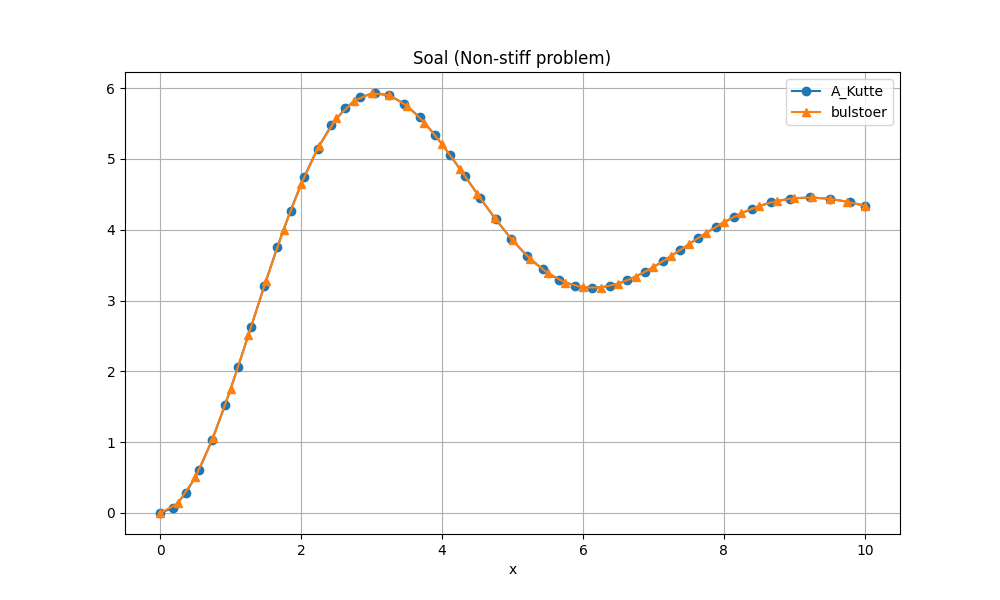

In [66]:
fig, ax = plt.subplots (figsize=(10, 6))
ax.plot (X_ak, Y_ak [:,0],'o-', X_bu,Y_bu[:,0],'^-')
plt.xlabel ('x')
plt.legend (('A_Kutte', 'bulstoer'), loc="best")
plt.grid (True)
plt.title ("Soal (Non-stiff problem)")
plt.show ()

#### Soal 2

In [67]:
def F(x,y):
    F = np.zeros(2)
    F[0] = y[1]
    F[1] = -4.75*y[0] - 10.0*y[1]
    return F

In [68]:
xStop = 10.0
# initial conditian
x = 0.0
y = np.array([-9.0, 0.0])
h = 0.1
freq = 4

X_ak,Y_ak = Adaptive_Runge_Kutta (F, x,y, xStop, h)
#X_k, Y_k = Kutte (F, x,y, xStop, h)
X_bu, Y_bu = bulStoer(F, x,y, xStop, h)

printSoln(X_ak, Y_ak,freq)
#input("\nPress return to exit")

iterasi ke [2]: 
 nilai f(x2, y2) = [-8.99338353  0.70854647] 
 nilai x = 0.018126408063619603
 h = 0.018126408063619603

iterasi ke [3]: 
 nilai f(x3, y3) = [-8.97361439  1.33032879] 
 nilai x = 0.037328467593828504
 h = 0.019202059530208905

iterasi ke [4]: 
 nilai f(x4, y4) = [-8.94178667  1.8571157 ] 
 nilai x = 0.05718746234475529
 h = 0.01985899475092678

iterasi ke [5]: 
 nilai f(x5, y5) = [-8.89883276  2.29994598] 
 nilai x = 0.07777431298034797
 h = 0.020586850635592683

iterasi ke [6]: 
 nilai f(x6, y6) = [-8.84560601  2.66821206] 
 nilai x = 0.09914123530034491
 h = 0.02136692231999695

iterasi ke [7]: 
 nilai f(x7, y7) = [-8.7828613   2.97055258] 
 nilai x = 0.12134762967498627
 h = 0.02220639437464136

iterasi ke [8]: 
 nilai f(x8, y8) = [-8.71125874  3.21485152] 
 nilai x = 0.14445970667637614
 h = 0.023112077001389873

iterasi ke [9]: 
 nilai f(x9, y9) = [-8.63136496  3.40827435] 
 nilai x = 0.1685516397199594
 h = 0.024091933043583248

iterasi ke [10]: 
 nilai f(x10, y1

##### Plotting

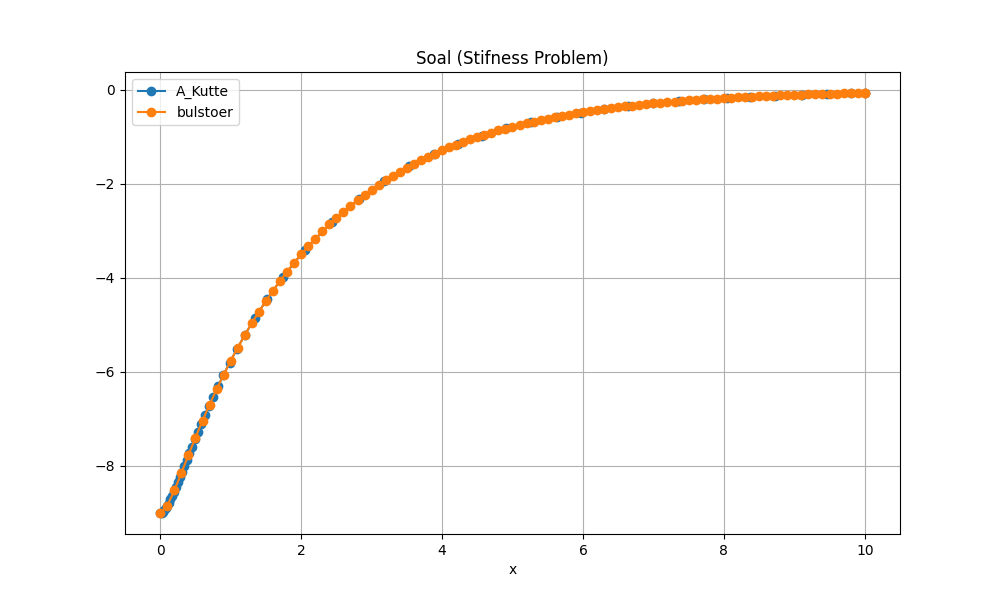

In [69]:
fig, ax = plt.subplots (figsize=(10, 6))
ax.plot (X_ak, Y_ak [:,0],'o-', X_bu,Y_bu[:,0],'o-')
plt.xlabel ('x')
plt.legend (('A_Kutte', 'bulstoer'), loc="best")
plt.grid (True)
plt.title ("Soal (Stifness Problem)")
plt.show ()